In [188]:
# Reinforcement Learning Problem 2
# Oscar Eriksson, 0011301991, oscer@kth.se
# Philip Ahrendt, 960605R119, pcah@kth.se
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

In [189]:
"""
    PROBLEM A, B, C
"""
A = 3 # left, stay, right
S = 2 # position and velocity in normalized space [0, 1]^2
p = 6 # order of kernel basis

# eta ~ (p, S)
eta = np.array([
#    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
    [2, 1],
    [1, 2],
])
p = eta.shape[0]

# w ~ (p, A)
w = np.random.normal(size=(p, A))
_w = np.ones((p, A))

# Q-function ~ (A,)
Q = lambda s: np.cos(np.pi * eta @ s).T @ w
# dQ-function ~ (p, A)
dQ = lambda s: np.cos(np.pi * eta @ s).reshape((p, 1)) * np.ones((1, A))

# hyper-parameters
gamma = 1.0 # \gamma
td = 0.7 # \lambda
alpha0 = 0.01 * 1 / np.maximum(np.linalg.norm(eta, axis=1), 1).reshape(-1,1)
epsilon0 = 0.2

# epsilon-greedy policy
policy = lambda s, epsilon: np.argmax(Q(s)) if np.random.rand() > epsilon else np.random.randint(A)

100%|██████████| 50/50 [00:02<00:00, 22.40it/s]


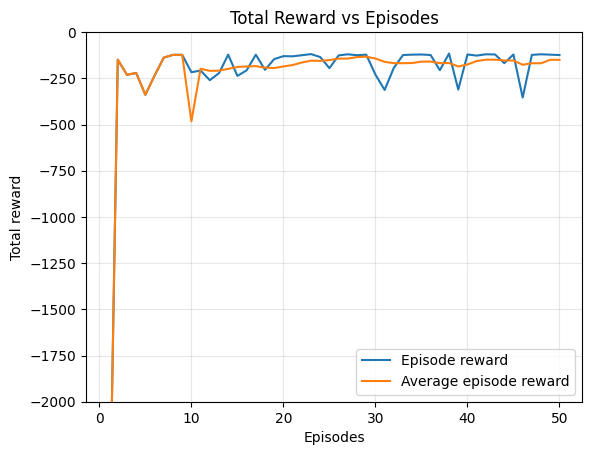

In [190]:
# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

# Parameters
N_episodes = 50       # Number of episodes to run for training
discount_factor = 1.    # Value of gamma

# Reward
episode_reward_list = []  # Used to save episodes reward

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x

# Training process
alpha = alpha0
epsilon = epsilon0
w = np.random.normal(size=(p, A))
for i in tqdm(range(N_episodes)):
    # we use these
    eligibility_trace = np.zeros_like(w) # eligibility trace
    v = np.zeros_like(w) # acceleration term

    # Reset enviroment data
    done = False
    state, _ = env.reset()
    state = scale_state_variables(state)
    action = policy(state, epsilon)
    total_episode_reward = 0.

    while not done:
        # Get next state, reward and action. The done variable
        next_state, reward, done, _, _ = env.step(action)
        next_state = scale_state_variables(next_state)
        next_action = policy(next_state, epsilon)

        """ /SARSA """
        temporal_difference_error = reward + gamma * Q(next_state)[next_action] - Q(state)[action]
        eligibility_trace[:, action] += dQ(state)[:, action]
        eligibility_trace = np.clip(gamma * td * eligibility_trace, -5, 5)

        # update weights
        v = 0.4 * v + alpha * eligibility_trace * temporal_difference_error
        w += 0.4 * v + alpha * eligibility_trace * temporal_difference_error
        """ SARSA/ """

        # Update episode reward
        total_episode_reward += reward
            
        # Update state for next iteration
        state = next_state
        action = next_action

    # Append episode reward
    episode_reward_list.append(total_episode_reward)
    alpha = alpha0 * (1 - np.exp(-np.abs(total_episode_reward) / 2000))
    epsilon = epsilon0 * np.exp(-0.5 * i / N_episodes)

    # Close environmen
    env.close()


# Plot Rewards
plt.plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
plt.plot([i for i in range(1, N_episodes+1)], running_average(episode_reward_list, 10), label='Average episode reward')
plt.ylim(-2000, 0)
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.title('Total Reward vs Episodes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [191]:
import pickle
data={'W':w.T, 'N':eta}
#pickle.dump(data, open("weights.pkl", "wb"))
#import check_solution

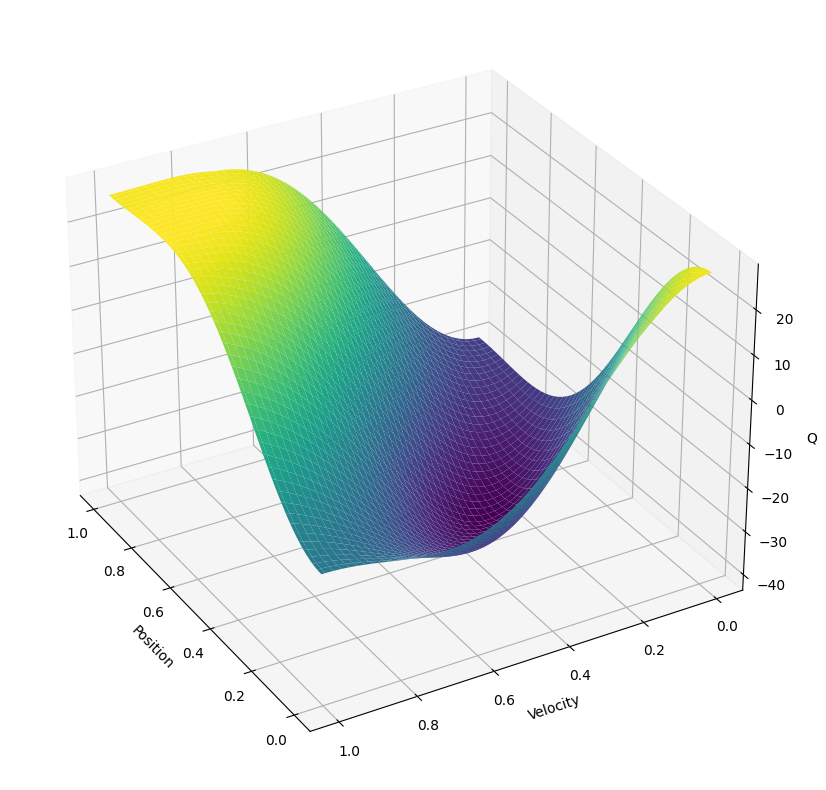

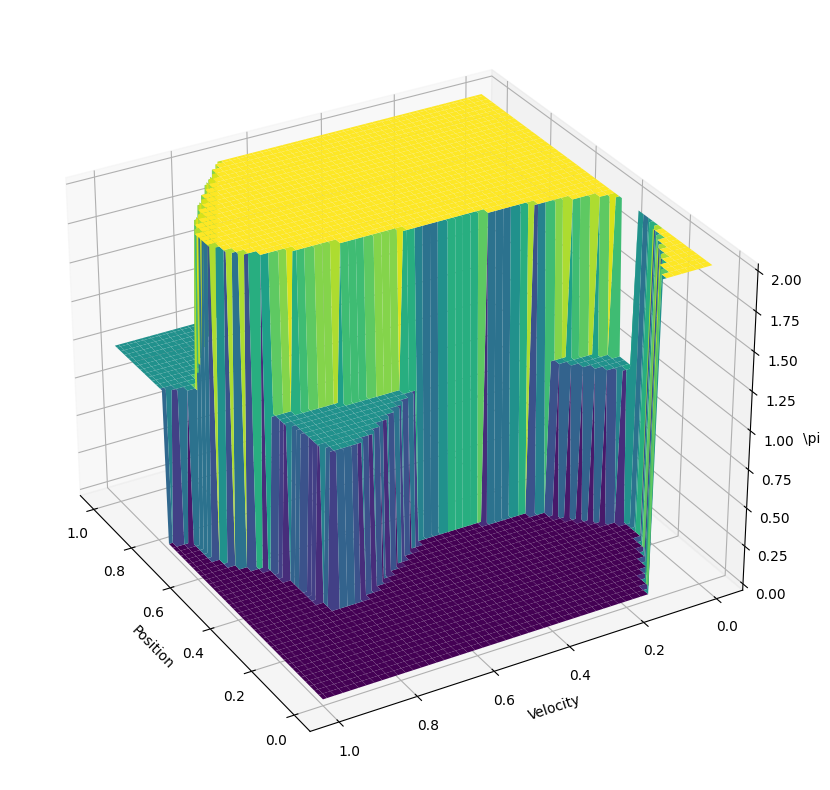

In [192]:
"""
    PROBLEM D
"""
# 3d plot of the optimal policy
s0 = np.linspace(0, 1, 100)
s1 = np.linspace(0, 1, 100)

S0, S1 = np.meshgrid(s0, s1)
S = np.stack([S0, S1], axis=2)
QV = np.zeros_like(S0)
PV = np.zeros_like(S0)
for i in range(100):
    for j in range(100):
        s = np.array([s0[i], s1[j]])
        QV[i, j] = np.max(Q(s))
        PV[i, j] = np.argmax(Q(s))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S0, S1, QV, cmap='viridis')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('Q')
# rotate 180 degrees
ax.view_init(30, 150)
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S0, S1, PV, cmap='viridis')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('\pi')
ax.view_init(30, 150)
plt.show()

In [193]:
# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

# Parameters
N_episodes = 50        # Number of episodes to run for training
discount_factor = 1.    # Value of gamma

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x

alphas = []
tr = []
lg = []
# Training process
for f in np.linspace(0.1, 10 / 4, 100 // 4):
    episode_reward_list = []
    eligibility_trace_list = []
    epsilon = epsilon0
    alpha = alpha0 * f * 10
    w = np.random.normal(size=(p, A))
    
    for i in range(N_episodes):
        # we use these
        eligibility_trace = np.zeros_like(w) # eligibility trace
        v = np.zeros_like(w) # acceleration term

        # Reset enviroment data
        done = False
        state, _ = env.reset()
        state = scale_state_variables(state)
        action = policy(state, epsilon)
        total_episode_reward = 0.

        while not done:
            # Get next state, reward and action. The done variable
            next_state, reward, done, _, _ = env.step(action)
            next_state = scale_state_variables(next_state)
            next_action = policy(next_state, epsilon)

            """ /SARSA """
            temporal_difference_error = reward + gamma * Q(next_state)[next_action] - Q(state)[action]
            eligibility_trace[:, action] += dQ(state)[:, action]
            eligibility_trace = np.clip(gamma * td * eligibility_trace, -5, 5)

            # update weights
            v = 0.4 * v + alpha * eligibility_trace * temporal_difference_error
            w += 0.4 * v + alpha * eligibility_trace * temporal_difference_error
            """ SARSA/ """

            # Update episode reward
            total_episode_reward += reward

            # Update state for next iteration
            state = next_state
            action = next_action

        # Append episode reward
        episode_reward_list.append(total_episode_reward)
        eligibility_trace_list.append(np.linalg.norm(eligibility_trace))
        epsilon = epsilon0 * np.exp(-0.5 * i / N_episodes)

        # Close environmen
        env.close()

    tr += [ episode_reward_list ]
    lg += [ eligibility_trace_list ]
    alphas += [ np.linalg.norm(alpha) ]

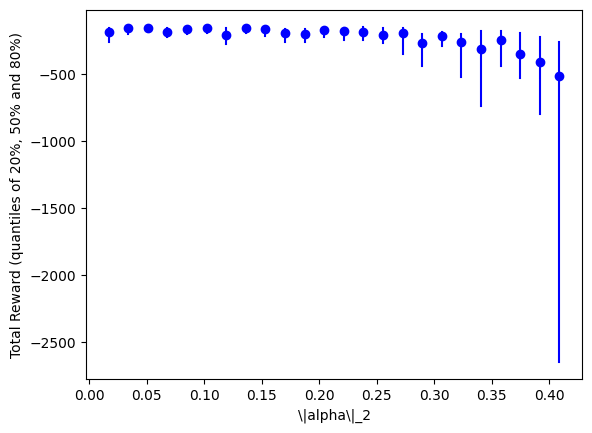

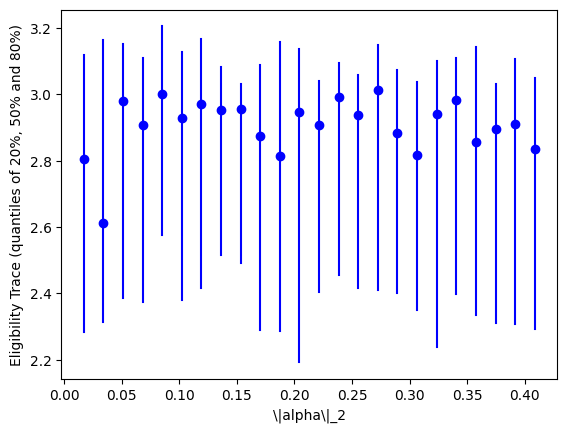

In [194]:
m = np.array(tr).mean()
for alpha, tdl in list(zip(alphas, tr))[:-1]:
    rmean = np.quantile(tdl, 0.5)
    rmin = np.quantile(tdl, 0.2)
    rmax = np.quantile(tdl, 0.8)
    
    plt.plot([alpha, alpha], [rmin, rmax], '-b')
    plt.plot([alpha], [rmean], 'ob')
plt.ylabel('Total Reward (quantiles of 20%, 50% and 80%)')
plt.xlabel('\|alpha\|_2')
plt.show()

m = np.array(lg).mean()
for alpha, tdl in list(zip(alphas, lg))[:-1]:
    rmean = np.quantile(tdl, 0.5)
    rmin = np.quantile(tdl, 0.2)
    rmax = np.quantile(tdl, 0.8)
    
    plt.plot([alpha, alpha], [rmin, rmax], '-b')
    plt.plot([alpha], [rmean], 'ob')
plt.ylabel('Eligibility Trace (quantiles of 20%, 50% and 80%)')
plt.xlabel('\|alpha\|_2')
plt.show()

In [195]:
# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

# Parameters
N_episodes = 300        # Number of episodes to run for training
discount_factor = 1.    # Value of gamma

# Reward
lq = []
w_list = []

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x

w_0 = np.zeros((p, A))
w_1 = np.ones((p, A))
w_r = np.random.normal(size=(p, A))
w_g = dQ(np.array([0.5, 0.5]))

for w in [w_0, w_1, w_r, w_g]:
    episode_reward_list = []  # Used to save episodes reward
    # Training process
    alpha = alpha0
    epsilon = epsilon0
    for i in tqdm(range(N_episodes)):
        # we use these
        eligibility_trace = np.zeros_like(w) # eligibility trace
        v = np.zeros_like(w) # acceleration term

        # Reset enviroment data
        done = False
        state, _ = env.reset()
        state = scale_state_variables(state)
        action = policy(state, epsilon)
        total_episode_reward = 0.

        while not done:
            # Get next state, reward and action. The done variable
            next_state, reward, done, _, _ = env.step(action)
            next_state = scale_state_variables(next_state)
            next_action = policy(next_state, epsilon)

            """ /SARSA """
            temporal_difference_error = reward + gamma * Q(next_state)[next_action] - Q(state)[action]
            eligibility_trace[:, action] += dQ(state)[:, action]
            eligibility_trace = np.clip(gamma * td * eligibility_trace, -5, 5)

            # update weights
            v = 0.4 * v + alpha * eligibility_trace * temporal_difference_error
            w += 0.4 * v + alpha * eligibility_trace * temporal_difference_error
            """ SARSA/ """

            # Update episode reward
            total_episode_reward += reward

            # Update state for next iteration
            state = next_state
            action = next_action

        # Append episode reward
        episode_reward_list.append(total_episode_reward)
        alpha = alpha0 * (1 - np.exp(-np.abs(total_episode_reward) / 2000))
        epsilon = epsilon0 * np.exp(-0.5 * i / N_episodes)

        # Close environmen
        env.close()
    w_list += [ w ]
    lq += [ episode_reward_list ]

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:10<00:00, 27.99it/s]


Text(0, 0.5, 'Total reward')

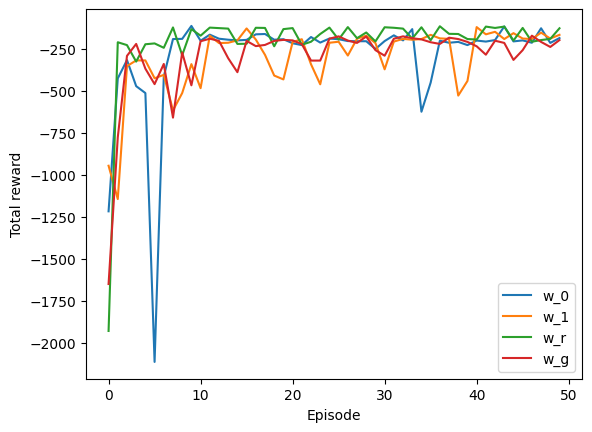

In [196]:
m = np.array(lq).mean()
for _w, tdl, desc in zip(w_list, lq, ['w_0', 'w_1', 'w_r', 'w_g']):
    
    r = np.array(tdl)[:50]
    plt.plot(r, label=desc)
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Total reward')

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 10.53it/s]


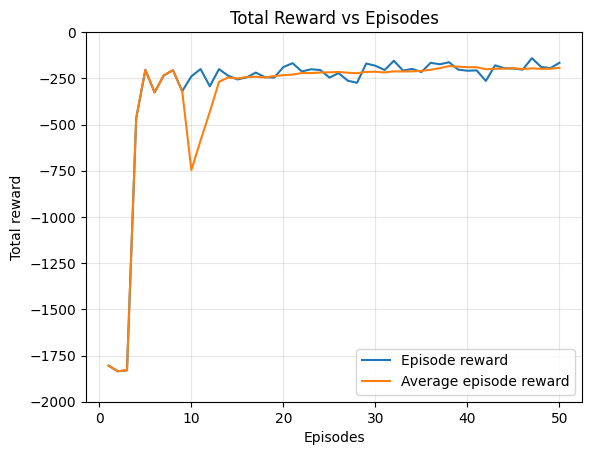

In [198]:
"""
    PROBLEM E
"""

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

# Parameters
N_episodes = 50        # Number of episodes to run for training
discount_factor = 1.    # Value of gamma

# Reward
episode_reward_list = []  # Used to save episodes reward

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x

# Training process
alpha = alpha0
epsilon = epsilon0
w = np.random.normal(size=(p, A))

for i in tqdm(range(N_episodes)):
    # we use these
    eligibility_trace = np.zeros_like(w) # eligibility trace
    v = np.zeros_like(w) # acceleration term

    def new_policy(s):
        a = np.argmax(Q(s))
        p = 1 / (np.abs(Q(s) - Q(s)[a]) + 0.1)
        a_choice = np.random.choice(np.arange(A), p = p / np.sum(p))

        return a_choice

    # Reset enviroment data
    done = False
    state, _ = env.reset()
    state = scale_state_variables(state)
    action = new_policy(state)
    total_episode_reward = 0.

    while not done:
        # Get next state, reward and action. The done variable
        next_state, reward, done, _, _ = env.step(action)
        next_state = scale_state_variables(next_state)
        next_action = new_policy(next_state)

        """ /SARSA """
        temporal_difference_error = reward + gamma * Q(next_state)[next_action] - Q(state)[action]
        eligibility_trace[:, action] += dQ(state)[:, action]
        eligibility_trace = np.clip(gamma * td * eligibility_trace, -5, 5)

        # update weights
        v = 0.4 * v + alpha * eligibility_trace * temporal_difference_error
        w += 0.4 * v + alpha * eligibility_trace * temporal_difference_error
        """ SARSA/ """

        # Update episode reward
        total_episode_reward += reward
            
        # Update state for next iteration
        state = next_state
        action = next_action

    # Append episode reward
    episode_reward_list.append(total_episode_reward)
    alpha = alpha0 * (1 - np.exp(-np.abs(total_episode_reward) / 2000))
    epsilon = epsilon0 * np.exp(-0.5 * i / N_episodes)

    # Close environmen
    env.close()

# Plot Rewards
plt.plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
plt.plot([i for i in range(1, N_episodes+1)], running_average(episode_reward_list, 10), label='Average episode reward')
plt.ylim(-2000, 0)
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.title('Total Reward vs Episodes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()